In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/HTSF')
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
from preprocess.hierarchical import TreeNodes
from preprocess import r_snippet
import numpy as np
import pandas as pd
from numpy.linalg import inv
from itertools import chain
import pdb

## Install hts packages

In [ ]:
'''
Description of hts package can be found at:
https://cran.r-project.org/web/packages/hts/hts.pdf
'''
package_names = ['stats', 'curl', 'MASS', 'mvtnorm', 'hts', 'magic', 'matrixcalc', 'Matrix']
if all(rpackages.isinstalled(x) for x in package_names):
    have_package = True
else:
    have_package = False

if not have_package:
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)

    package_to_install = [x for x in package_names if not rpackages.isinstalled(x)]
    print(package_to_install)
    if len(package_to_install) > 0:
        utils.install_packages(StrVector(package_to_install))

## ERM Reconciliation

In [ ]:
'''
Please refer to Eq(18) from paper http://souhaib-bentaieb.com/pdf/2019_KDD.pdf
There are no developed packages for this method.
'''
def get_p_matrix(S, Y, Y_hat):
    try:
        P = -np.dot(np.dot(inv(np.dot(S.T, S)), np.dot(S.T, Y.T)), np.dot(Y_hat, inv(np.dot(Y_hat.T, Y_hat))))
        return P
    except ValueError:
        print('Solution of P is not unique as some matrices are not invertible.')


def ERM(nodes, y, y_hat):
    S = TreeNodes(nodes).get_s_matrix()
    P = get_p_matrix(S, y, y_hat)
    result = []
    for i in range(y_hat.shape[0]):
        recon_pred = {}
        y_tilde = np.dot(np.dot(S, P), y_hat[i, :])
        for i, e in enumerate(y_tilde):
            recon_pred[str(i)] = e
        if y_hat.shape[0] == 1:
            return recon_pred
        result.append(recon_pred)
    return result

## MinT Reconciliation (balanced graph only)

In [ ]:
'''
Description of this method can be found at 
https://www.tandfonline.com/doi/abs/10.1080/01621459.2018.1448825

This method is implemented as a function in hts package.
However, the MinT function does not allow cases where the graph is unbalanced, 
i.e., distances from top nodes to leaves are unequal.
'''
def MinT(node_list, nodes, forecast, recon):
    pred = np.zeros((1, sum(list(chain(*nodes))) + 1))
    for name in node_list:
        pred[0, int(name)] = forecast[name]

    rpy2.robjects.numpy2ri.activate()
    nr, nc = pred.shape
    pred_r = ro.r.matrix(pred, nrow=nr, ncol=nc)

    feed_dict = {}
    for i, e in enumerate(nodes):
        if len(e) == 1:
            feed_dict['Level ' + str(i)] = e[0]
        else:
            feed_dict['Level ' + str(i)] = ro.IntVector(e)
    node_structure = ro.ListVector(feed_dict)

    # Assume 200 training samples, we simulate the in-sample residual from a Gaussian distribution.
    # You need to compute the residual by yourself in real experiment.
    residual = np.random.normal(loc=1.0, scale=2.0, size=(200, len(node_list)))
    nr, nc = residual.shape
    residual_r = ro.r.matrix(residual, nrow=nr, ncol=nc)

    hts = importr('hts')
    MinT = hts.MinT
    combinef = hts.combinef
    if recon == 'mint_shr':
        mint = r_snippet.mint_shr()
    elif recon == 'mint_sam':
        mint = r_snippet.mint_sam()
    else:
        mint = r_snippet.mint_ols()

    try:
        powerpack = SignatureTranslatedAnonymousPackage(mint, "powerpack")
        recon_pred = powerpack.mint_recon(pred_r, node_structure, residual_r)
    except ValueError:
        print('MinT does not apply here as covariance matrix is not positive definite.')

    recon_pred = np.array(recon_pred)
    forecast_recon = {}
    for i, e in enumerate(recon_pred[0]):
        forecast_recon[str(i)] = e
    return forecast_recon

## GLS Reconciliation

In [ ]:
'''
Description of this method can be found at Eq (8) of
https://openresearch-repository.anu.edu.au/bitstream/1885/196566/6/Hierarchical6.pdf 
'''

def GLS(S, forecast):
    epsilon = np.random.normal(loc=0, scale=1, size=S.shape[0])
    sigma = np.dot(np.expand_dims(epsilon - epsilon.mean(), axis=1), np.expand_dims(epsilon - epsilon.mean(), axis=0)) / S.shape[0]
    temp_1 = inv(np.dot(np.dot(S.T, inv(sigma)), S)) 
    temp_2 = np.dot(S.T, inv(sigma))
    P = np.dot(temp_1, temp_2)
    recon_pred = np.dot(S, np.dot(P, forecast))
    forecast_recon = {}
    for i, e in enumerate(recon_pred):
        forecast_recon[str(i)] = e
    return forecast_recon

## Evaluation metrics

In [ ]:
'''
Compute coherency error (whether the forecast will add up), and MAPE loss by
each aggregation level.
'''
def consistency_error(parent, childs, test_pred):
    '''
    Calculate the absolute difference between parent and child forecasts.
    :param parent: name of parent node
    :param childs: name of child nodes
    :param test_pred: forecasting results for each node
    :return: consistency error for a single parent-childs group
    '''
    child_pred = 0
    for child in childs:
        child_pred += test_pred[child]
    consistency_error = np.absolute(test_pred[parent] - child_pred)
    return consistency_error


def get_consistency(nodes, node_list, test_pred):
    total_error = 0
    for name in node_list:
        node = TreeNodes(nodes, name=name)
        if node.get_child() is not None:
            total_error += consistency_error(name, node.get_child()[1:], test_pred)
    return total_error


def get_mape_loss(node_list, nodes, pred, test, l):
    level_loss = dict(zip(range(l), np.zeros(l)))
    for name in node_list:
        node = TreeNodes(nodes, name=name)
        loss = 100 * np.absolute(np.array(test[int(name)] - pred[name])) / np.absolute(test[int(name)])
        level_loss[node.get_levels()] += loss
    for l in range(1, len(level_loss) + 1):
        level_loss[l - 1] = level_loss[l - 1] / len(TreeNodes(nodes).nodes_by_level(l))
    return np.fromiter(level_loss.values(), dtype=float)

## Test MinT and ERM

In [ ]:
'''
Demo on how to use above functions:
The model training part is ommited here. We randomly sample leaf node values
and use S matrix to aggregate up as the ground truth, then adding Gaussian 
noise as predictions.
'''
nodes = [[2], [2, 2], [8, 8, 8, 8]]
S = TreeNodes(nodes).get_s_matrix()
y_bot = 10 * np.random.sample(size=S.shape[1]) + 10
y = np.dot(S, y_bot)
y_hat = y + np.random.normal(loc=1, scale=3, size=S.shape[0])

node_list = [str(i) for i in range(len(y))]
pred, true = dict(zip(node_list, y_hat)), dict(zip(node_list, y))
coherency_error = get_consistency(nodes, node_list, pred)
print('Prediction coherency error: ', coherency_error)

y_gls = GLS(S, y_hat)
print('GLS reconciled coherency error: ', get_consistency(nodes, node_list, y_gls))

y_mint = MinT(node_list, nodes, pred, 'mint_shr')
print('MinT reconciled coherency error: ', get_consistency(nodes, node_list, y_mint))

y_erm = ERM(nodes, np.expand_dims(y, axis=0), np.expand_dims(y_hat, axis=0))
print('ERM reconciled coherency error: ', get_consistency(nodes, node_list, y_erm))

print('\n')
mape_pred = get_mape_loss(node_list, nodes, pred, y, len(nodes) + 1)
mape_gls = get_mape_loss(node_list, nodes, y_gls, y, len(nodes) + 1)
mape_mint = get_mape_loss(node_list, nodes, y_mint, y, len(nodes) + 1)
mape_erm = get_mape_loss(node_list, nodes, y_erm, y, len(nodes) + 1)
print('Prediction MAPE: ', mape_pred)
print('GLS Reconciled MAPE ', mape_gls)
print('MinT Reconciled MAPE ', mape_mint)
print('ERM Reconciled MAPE ', mape_erm)

Prediction coherency error:  39.29651309696905
GLS reconciled coherency error:  1.2789769243681803e-13
MinT reconciled coherency error:  5.684341886080802e-14
ERM reconciled coherency error:  2.0691004465334117e-11


Prediction MAPE:  [ 0.98235956  0.6941392   3.47170269 13.38298205]
GLS Reconciled MAPE  [ 0.50247853  1.20152804  5.70684952 58.90152112]
MinT Reconciled MAPE  [ 0.61365038  1.04872126  2.64348435 13.15867296]
ERM Reconciled MAPE  [1295.82074985 1295.82074985 1295.82074985 1295.82074985]


## Graph and S matrix

In [ ]:
# Balanced graph
nodes = [[2], [3, 3], [2, 2, 2, 2, 2, 2]]
S = TreeNodes(nodes).get_s_matrix()
print('S matrix for a balanced graph: \n', S)

# Unbalanced graph
nodes = [[3], [3, 0, 2], [0, 2, 0, 2, 0]]
S = TreeNodes(nodes).get_s_matrix()
print('S matrix for an unbalanced graph: \n', S)

S matrix for a balanced graph: 
 [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
S matrix for an unbalanced graph: 
 [[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1.]
 [1

## Test SHARQ

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Training node 7 
Epoch [0]: training 0.5 quantile loss in node 7: 4760355.0
Epoch [1]: training 0.5 quantile loss in node 7: 7883166.5
Epoch [2]: training 0.5 quantile loss in node 7: 315326.9375
Epoch [3]: training 0.5 quantile loss in node 7: 12613.1103515625
Epoch [4]: training 0.5 quantile loss in node 7: 504.526611328125
Epoch [5]: training 0.5 quantile loss in node 7: 20.181941986083984
Epoch [6]: training 0.5 quantile loss in node 7: 0.4493408203125
Epoch [7]: training 0.5 quantile loss in node 7: 0.29931640625
Epoch [8]: training 0.5 quantile loss in node 7: 0.1492919921875
Epoch [9]: training 0.5 quantile loss in node 7: 0.000732421875
Epoch [10]: training 0.5 quantile loss in node 7: 0.1492919921875


Training node 8 
Epoch [0]: training 0.5 quantile loss in node 8: 3298128.25
Epoch [1]: training 0.5 quantile loss in node 8: 1966273.625
Epoch [2]: training 0.5 quantile loss in node 8: 78651.0078125
Epoch [3]: training 0.5 quantile loss in node 8: 3146.056884765625
Epoch [4]: 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch [0]: training boundary quantile loss in node 0: 182713152.0
Epoch [1]: training boundary quantile loss in node 0: 125870256.0
Epoch [2]: training boundary quantile loss in node 0: 20139242.0
Epoch [3]: training boundary quantile loss in node 0: 3222279.0
Epoch [4]: training boundary quantile loss in node 0: 515564.5
Epoch [5]: training boundary quantile loss in node 0: 82490.5
Epoch [6]: training boundary quantile loss in node 0: 13198.521484375
Epoch [7]: training boundary quantile loss in node 0: 2111.71875
Epoch [8]: training boundary quantile loss in node 0: 337.8962097167969
Epoch [9]: training boundary quantile loss in node 0: 54.053306579589844
Epoch [10]: training boundary quantile loss in node 0: 3.001953125
Epoch [11]: training boundary quantile loss in node 0: 2.4595701694488525
Epoch [12]: training boundary quantile loss in node 0: 1.9163085222244263
Epoch [13]: training boundary quantile loss in node 0: 1.3739745616912842
Epoch [14]: training boundary quantile loss i

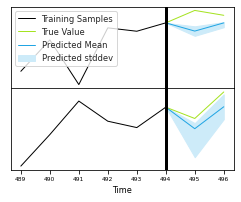

In [ ]:
'''
Demo on how to use SHARQ:
Run RNN model on Australian Labour force dataset (4 aggregation levels).
You can run more advanced forecasting algorithms with other reconciliation 
methods on both time series and sequential data.
'''
from sharq import sharq
import os

sharq_model = sharq(DATASET='labour', FORECAST_GRANULARITY='M', 
                    IS_HIERARCHICAL=True, FORECAST_HORIZON=2,
                    VERBOSE=True, TRAINING_METHOD='sharq',
                    DIR='/content/drive/My Drive/HTSF')

sharq_model.fit_and_predict()